In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
from pathlib import Path


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='imputation', key_added_pred='impute_mclust',
             random_seed=666):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """

    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(adata.obsm[used_obsm], num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs[key_added_pred] = mclust_res
    adata.obs[key_added_pred] = adata.obs[key_added_pred].astype('int')
    adata.obs[key_added_pred] = adata.obs[key_added_pred].astype('category')
    return adata


In [2]:
import STMGAC

In [3]:
proj_name = 'BRCA'
num_clusters = 20

In [4]:
with open('../Config/BRCA.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)  

In [5]:
adata = sc.read_visium('D:/project/datasets/BRCA1/V1_Human_Breast_Cancer_Block_A_Section_1',
                                   count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

##### Load layer_guess label, if have
turth_path = 'D:/project/datasets/BRCA1/metadata.tsv'
truth_labels = pd.read_csv(turth_path, sep='\t', header=0)
truth_labels.index = adata.obs_names
adata.obs['layer_guess'] = truth_labels['fine_annot_type']
# adata = adata[~pd.isnull(adata.obs['layer_guess'])]

graph_dict = STMGAC.graph_construction(adata, config['data']['k_cutoff'])

adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count',
                            n_top_genes=config['data']['top_genes'])
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = STMGAC.Mgac(adata, graph_dict=graph_dict, num_clusters=num_clusters, device=device, config=config)

In [7]:
net.trian()

Epoch 999 total loss=1.211 recon loss=0.937 mean loss=0.734 tri loss=0.201: 100%|██████████| 1000/1000 [01:13<00:00, 13.59it/s]


In [8]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon


In [9]:
adata = mclust_R(adata, num_cluster=num_clusters, used_obsm='latent', key_added_pred='mclust')
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = ari_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(ARI)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
0.6837867533817381


[<Axes: title={'center': 'mclust'}, xlabel='spatial1', ylabel='spatial2'>]

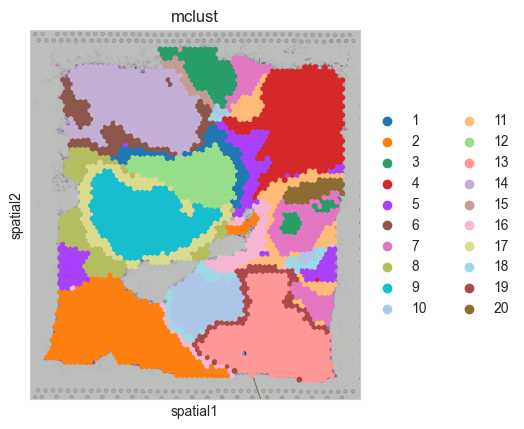

In [10]:
sc.pl.spatial(adata, color=['mclust'], show=False, spot_size=320)

In [11]:
adata.obs["mclust"] = adata.obs["mclust"].values.astype(str)
adata.layers["recon"] = adata.obsm["recon"]

In [12]:
d1 = '20'
d2 = '4'
key1 = d1 + 'vs' + d2
key2 = d2 + 'vs' + d1
log2fc_min = 2

sc.tl.rank_genes_groups(adata, "mclust", groups=[d1], reference=d2, key_added=key1, layer='recon')
sc.tl.rank_genes_groups(adata, "mclust", groups=[d2], reference=d1, key_added=key2, layer='recon')
g_1 = list(sc.get.rank_genes_groups_df(adata, group=d1, key=key1, pval_cutoff=0.05, log2fc_min=log2fc_min)['names'])
g_2 = list(sc.get.rank_genes_groups_df(adata, group=d2, key=key2, pval_cutoff=0.05, log2fc_min=log2fc_min)['names'])
len(g_1), len(g_2)

(81, 502)

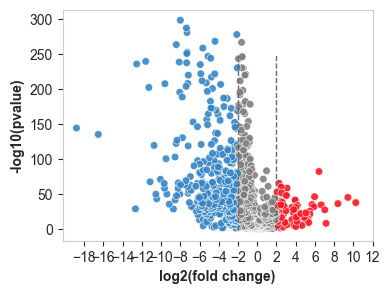

In [13]:
key = key1

pvals_adj = [i[0] for i in adata.uns[key]["pvals_adj"]]
pvals = [i[0] for i in adata.uns[key]["pvals"]]
logfoldchanges = [i[0] for i in adata.uns[key]["logfoldchanges"]]
import seaborn as sns  # Statistical visualization
import matplotlib.pyplot as plt
result = pd.DataFrame()
result['x'] = logfoldchanges
result['y'] = -np.log10(pvals)

cut_off_logFC = log2fc_min
fig, ax = plt.subplots(figsize=(4, 3))
result.loc[(result.x > cut_off_logFC), 'group'] = 'up'
result.loc[(result.x < -cut_off_logFC), 'group'] = 'down'
result.loc[(result.x >= -cut_off_logFC) & (result.x <= cut_off_logFC), 'group'] = 'normal'

ax = sns.scatterplot(x="x", y="y",
                     ax=ax,
                     hue='group',
                     hue_order=('down', 'normal', 'up'),
                     palette=("#3686C5", "grey", "#FF1623"),
                     alpha=0.9,
                     s=30,
                     legend=None,
                     data=result)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# 
ax.vlines(-cut_off_logFC, -2, 250, color='dimgrey', linestyle='dashed', linewidth=1)
ax.vlines(cut_off_logFC, -2, 250, color='dimgrey', linestyle='dashed', linewidth=1) 
ax.set_xticks(range(-18, 14, 2)) 
ax.set_yticks(range(0, 301, 50)) 
ax.set_ylabel('-log10(pvalue)', fontweight='bold')  
ax.set_xlabel('log2(fold change)', fontweight='bold') 
ax.grid(False)